# Object detection
Object detection using YOLO (You Only Look Once) is a real-time object detection algorithm that is both fast and accurate. YOLO treats object detection as a single regression problem, directly predicting bounding boxes and class probabilities from full images in one evaluation.
## YOLO V2 608X608


In [1]:
import argparse
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
from PIL import ImageFont, ImageDraw, Image
import tensorflow as tf
from tensorflow.python.framework.ops import EagerTensor
import cv2
import numpy as np
from PIL import ImageGrab
import mss
import mss.tools
from tensorflow.keras.models import load_model
from yad2k.models.keras_yolo import yolo_head
from yad2k.utils.utils import draw_boxes,draw_boxes1, get_colors_for_classes, scale_boxes, read_classes, read_anchors, preprocess_image,preprocess_image_realtime,draw_boxes_realtime



# YOLO ALGORITHM
YOLO ("you only look once") is a popular algoritm because it achieves high accuracy while also being able to run in real-time. This algorithm "only looks once" at the image in the sense that it requires only one forward propagation pass through the network to make predictions. After non-max suppression, it then outputs recognized objects together with the bounding boxes.
## MODEL DETAILS
The input is a batch of images of shape (m, 608, 608, 3)
The output is a list of bounding boxes along with the recognized classes. Each bounding box is represented by 6 numbers (Pc,Bx,By,Bh,Bw,C)
 as explained above. If you expand 
 into an 80-dimensional vector, each bounding box is then represented by 85 numbers.
We will use 5 anchor boxes. So you can think of the YOLO architecture as the following: IMAGE (m, 608, 608, 3) -> DEEP CNN -> ENCODING (m, 19, 19, 5, 85).

In [2]:
def yolo_filter_boxes(boxes, box_confidence, box_class_probs, threshold = 0.6):
    """Filters YOLO boxes by thresholding on object and class confidence.
    
    Arguments:
        boxes -- tensor of shape (19, 19, 5, 4)
        box_confidence -- tensor of shape (19, 19, 5, 1)
        box_class_probs -- tensor of shape (19, 19, 5, 80)
        threshold -- real value, if [ highest class probability score < threshold],
                     then get rid of the corresponding box

    Returns:
        scores -- tensor of shape (None,), containing the class probability score for selected boxes
        boxes -- tensor of shape (None, 4), containing (b_x, b_y, b_h, b_w) coordinates of selected boxes
        classes -- tensor of shape (None,), containing the index of the class detected by the selected boxes

    Note: "None" is here because you don't know the exact number of selected boxes, as it depends on the threshold. 
    For example, the actual output size of scores would be (10,) if there are 10 boxes.
    """
    
    x = 10
    y = tf.constant(100)
    
    # YOUR CODE STARTS HERE

    # Step 1: Compute box scores
    ##(≈ 1 line)
    box_scores = box_class_probs*box_confidence
    
    # Step 2: Find the box_classes using the max box_scores, keep track of the corresponding score
    ##(≈ 2 lines)
    box_classes = tf.math.argmax(box_scores,axis=-1)
    box_class_scores = tf.math.reduce_max(box_scores,axis=-1)
    
    # Step 3: Create a filtering mask based on "box_class_scores" by using "threshold". The mask should have the
    # same dimension as box_class_scores, and be True for the boxes you want to keep (with probability >= threshold)
    ## (≈ 1 line)
    filtering_mask = (box_class_scores >= threshold)
    
    # Step 4: Apply the mask to box_class_scores, boxes and box_classes
    ## (≈ 3 lines)
    scores = tf.boolean_mask(box_class_scores,filtering_mask)
    boxes = tf.boolean_mask(boxes,filtering_mask)
    classes = tf.boolean_mask(box_classes,filtering_mask)
    
    # YOUR CODE ENDS HERE
    
    return scores, boxes, classes

## Non max suppression

In [3]:
def iou(box1, box2):
    """Implement the intersection over union (IoU) between box1 and box2
    
    Arguments:
    box1 -- first box, list object with coordinates (x1, y1, x2, y2)
    box2 -- second box, list object with coordinates (x1, y1, x2, y2)
    """

    # Calculate the (y1, x1, y2, x2) coordinates of the intersection of box1 and box2. Calculate its Area.
    ### START CODE HERE ### (≈ 5 lines)
    
    x1=np.max([box1["x1"],box2["x1"]])
    y1=np.max([box1["y1"],box2["y1"]])
    x2=np.min([box1["x2"],box2["x2"]])
    y2=np.min([box1["y2"],box2["y2"]])
    intersectionArea=(y2-y1)*(x2-x1)
    
    
    
    
    
    ### END CODE HERE ###    

    # Calculate the Union area by using Formula: Union(A,B) = A + B - Inter(A,B)
    ### START CODE HERE ### (≈ 3 lines)
    areaA=(box1["y2"]-box1["y1"])*(box1["x2"]-box1["x1"])
    areaB=(box1["y2"]-box2["y1"])*(box2["x2"]-box2["x1"])
    unionArea=areaA+areaB-intersectionArea
    
    
    ### END CODE HERE ###
    
    # compute the IoU
    ### START CODE HERE ### (≈ 1 line)
    iou=intersectionArea/unionArea
    ### END CODE HERE ###

    return iou


In [4]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    """
    Applies Non-max suppression (NMS) to set of boxes
    
    Arguments:
    scores -- tensor of shape (None,), output of yolo_filter_boxes()
    boxes -- tensor of shape (None, 4), output of yolo_filter_boxes() that have been scaled to the image size (see later)
    classes -- tensor of shape (None,), output of yolo_filter_boxes()
    max_boxes -- integer, maximum number of predicted boxes you'd like
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (, None), predicted score for each box
    boxes -- tensor of shape (4, None), predicted box coordinates
    classes -- tensor of shape (, None), predicted class for each box
    
    Note: The "None" dimension of the output tensors has obviously to be less than max_boxes. Note also that this
    function will transpose the shapes of scores, boxes, classes. This is made for convenience.
    """
    
    max_boxes_tensor = tf.Variable(max_boxes, dtype='int32')     # tensor to be used in tf.image.non_max_suppression()
    
    # Use tf.image.non_max_suppression() to get the list of indices corresponding to boxes you keep
    ##(≈ 1 line)
    nms_indices = tf.image.non_max_suppression(boxes,scores,max_boxes_tensor,iou_threshold)
    
    # Use tf.gather() to select only nms_indices from scores, boxes and classes
    ##(≈ 3 lines)
    scores = tf.gather(scores,nms_indices)
    boxes = tf.gather(boxes,nms_indices)
    classes = tf.gather(classes,nms_indices)
    # YOUR CODE STARTS HERE
    
    
    # YOUR CODE ENDS HERE

    
    return scores, boxes, classes


## Building an function which can take yolo encoding i.e that 19x19x425

In [5]:
def yolo_boxes_to_corners(box_xy, box_wh):
    """Convert YOLO box predictions to bounding box corners."""
    box_mins = box_xy - (box_wh / 2.)
    box_maxes = box_xy + (box_wh / 2.)

    return tf.keras.backend.concatenate([
        box_mins[..., 1:2],  # y_min
        box_mins[..., 0:1],  # x_min
        box_maxes[..., 1:2],  # y_max
        box_maxes[..., 0:1]  # x_max
    ])
def yolo_eval(yolo_outputs, image_shape = (720, 1280), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    """
    Converts the output of YOLO encoding (a lot of boxes) to your predicted boxes along with their scores, box coordinates and classes.
    
    Arguments:
    yolo_outputs -- output of the encoding model (for image_shape of (608, 608, 3)), contains 4 tensors:
                    box_xy: tensor of shape (None, 19, 19, 5, 2)
                    box_wh: tensor of shape (None, 19, 19, 5, 2)
                    box_confidence: tensor of shape (None, 19, 19, 5, 1)
                    box_class_probs: tensor of shape (None, 19, 19, 5, 80)
    image_shape -- tensor of shape (2,) containing the input shape, in this notebook we use (608., 608.) (has to be float32 dtype)
    max_boxes -- integer, maximum number of predicted boxes you'd like
    score_threshold -- real value, if [ highest class probability score < threshold], then get rid of the corresponding box
    iou_threshold -- real value, "intersection over union" threshold used for NMS filtering
    
    Returns:
    scores -- tensor of shape (None, ), predicted score for each box
    boxes -- tensor of shape (None, 4), predicted box coordinates
    classes -- tensor of shape (None,), predicted class for each box
    """
    
    
    # Retrieve outputs of the YOLO model (≈1 line)
    box_xy, box_wh, box_confidence, box_class_probs = yolo_outputs

    # Convert boxes to be ready for filtering functions (convert boxes box_xy and box_wh to corner coordinates)
    boxes = yolo_boxes_to_corners(box_xy, box_wh)

    # Use one of the functions you've implemented to perform Score-filtering with a threshold of score_threshold (≈1 line)
    scores, boxes, classes = yolo_filter_boxes(boxes, box_confidence, box_class_probs, score_threshold)
    
    # Scale boxes back to original image shape (720, 1280 or whatever)
    boxes = scale_boxes(boxes, image_shape) # Network was trained to run on 608x608 images

    # Use one of the functions you've implemented to perform Non-max suppression with 
    # maximum number of boxes set to max_boxes and a threshold of iou_threshold (≈1 line)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes, iou_threshold)
    
    # YOUR CODE STARTS HERE
    
    
    # YOUR CODE ENDS HERE
    
    return scores, boxes, classes


## Testing yolo pretrained model

In [6]:
class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt")
model_image_size = (608, 608)

# Loading Yolo model

In [7]:
yolo_model = load_model("model_data/yolo.h5", compile=False)

In [8]:
yolo_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 608, 608, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 608, 608, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 608, 608, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

## Verifying the output of yolov2 model it should be 19x19x5x85


In [9]:
image, image_data = preprocess_image("images/" + "0013.jpg", model_image_size = (608, 608))
yolo_model(image_data)

<tf.Tensor: shape=(1, 19, 19, 425), dtype=float32, numpy=
array([[[[ 0.16598085,  0.06344066, -0.63809997, ...,  0.0519717 ,
          -0.43094102,  0.89659655],
         [-0.47430265, -1.3229517 ,  0.01731503, ..., -0.6854946 ,
          -0.8080063 ,  1.0002476 ],
         [-0.19573435, -0.996921  , -0.05073985, ..., -0.07889975,
          -1.1607759 ,  0.6109582 ],
         ...,
         [-0.27115458, -1.4929718 ,  0.2135601 , ..., -0.03159902,
          -1.0076019 , -0.28161478],
         [ 0.9395112 , -1.6664239 ,  0.40050063, ..., -0.39380014,
          -1.0080928 , -0.19240451],
         [-0.42684945, -0.16049474, -0.12282832, ..., -0.20146278,
          -0.8483551 ,  0.09783258]],

        [[-1.2200077 , -0.71528167, -1.4464685 , ...,  0.56930554,
          -0.51418024,  0.9468337 ],
         [-0.02555573,  0.66181034, -1.099777  , ..., -0.9533069 ,
          -0.66653365,  1.1209757 ],
         [-0.6720422 ,  0.47953784, -0.7906382 , ..., -0.6373268 ,
          -0.9082987 ,  0.3

## Predict function which will put everything together

In [10]:
def predict(image_file):
    """
    Runs the graph to predict boxes for "image_file". Prints and plots the predictions.
    
    Arguments:
    image_file -- name of an image stored in the "images" folder.
    
    Returns:
    out_scores -- tensor of shape (None, ), scores of the predicted boxes
    out_boxes -- tensor of shape (None, 4), coordinates of the predicted boxes
    out_classes -- tensor of shape (None, ), class index of the predicted boxes
    
    Note: "None" actually represents the number of predicted boxes, it varies between 0 and max_boxes. 
    """

    # Preprocess your image
    image, image_data = preprocess_image("images/" + image_file, model_image_size = (608, 608))
    #image, image_data = preprocess_image_realtime(image_file, model_image_size = (608, 608))
    
    yolo_model_outputs = yolo_model(image_data) # It's output is of shape (m, 19, 19, 5, 85) 
    # But yolo_eval takes input a tensor contains 4 tensors: box_xy,box_wh, box_confidence & box_class_probs
    yolo_outputs = yolo_head(yolo_model_outputs, anchors, len(class_names))
    
    out_scores, out_boxes, out_classes = yolo_eval(yolo_outputs, [image.size[1],  image.size[0]], 10, 0.3, 0.5)

    # Print predictions info
    print('Found {} boxes for {}'.format(len(out_boxes), "images/" + image_file))
    # Generate colors for drawing bounding boxes.
    colors = get_colors_for_classes(len(class_names))
    # Draw bounding boxes on the image file
    #draw_boxes2(image, out_scores, out_boxes, out_classes, class_names, colors, image_shape)
    draw_boxes(image, out_boxes, out_classes, class_names, out_scores)
    # Save the predicted bounding box on the image
    image.save(os.path.join("out", str(image_file).split('.')[0]+"_annotated." +str(image_file).split('.')[1] ), quality=100)
    # Display the results in the notebook
    output_image = Image.open(os.path.join("out", str(image_file).split('.')[0]+"_annotated." +str(image_file).split('.')[1] ))
    imshow(output_image)

    return out_scores, out_boxes, out_classes

## To get output realtime use this function note it accepts an image array rather than path

In [11]:
def predict_realtime(image_arr):
    """
    Runs the graph to predict boxes for "image_file". Prints and plots the predictions.
    
    Arguments:
    image_file -- name of an image stored in the "images" folder.
    
    Returns:
    out_scores -- tensor of shape (None, ), scores of the predicted boxes
    out_boxes -- tensor of shape (None, 4), coordinates of the predicted boxes
    out_classes -- tensor of shape (None, ), class index of the predicted boxes
    
    Note: "None" actually represents the number of predicted boxes, it varies between 0 and max_boxes. 
    """

    # Preprocess your image
    #image, image_data = preprocess_image("images/" + image_file, model_image_size = (608, 608))
    image, image_data = preprocess_image_realtime(image_arr, model_image_size = (608, 608))
    
    yolo_model_outputs = yolo_model(image_data) # It's output is of shape (m, 19, 19, 5, 85) 
    # But yolo_eval takes input a tensor contains 4 tensors: box_xy,box_wh, box_confidence & box_class_probs
    yolo_outputs = yolo_head(yolo_model_outputs, anchors, len(class_names))
    
    out_scores, out_boxes, out_classes = yolo_eval(yolo_outputs, [image.shape[1],  image.shape[0]], 10, 0.3, 0.5)

    # Print predictions info
    #print('Found {} boxes for {}'.format(len(out_boxes), "images/" + image_file))
    # Generate colors for drawing bounding boxes.
    colors = get_colors_for_classes(len(class_names))
    # Draw bounding boxes on the image file
    #draw_boxes2(image, out_scores, out_boxes, out_classes, class_names, colors, image_shape)
    op=draw_boxes_realtime(image, out_boxes, out_classes, class_names, out_scores)
    # Save the predicted bounding box on the image
    #image.save(os.path.join("out", str(image_file).split('.')[0]+"_annotated." +str(image_file).split('.')[1] ), quality=100)
    # Display the results in the notebook
    #output_image = Image.open(os.path.join("out", str(image_file).split('.')[0]+"_annotated." +str(image_file).split('.')[1] ))
    #imshow(output_image)

    return out_scores, out_boxes, out_classes,op

## Testing on a image

Found 3 boxes for images/0019.jpg
car 0.85 (16, 377) (450, 559)
truck 0.64 (713, 280) (1052, 390)
traffic light 0.42 (201, 188) (224, 222)


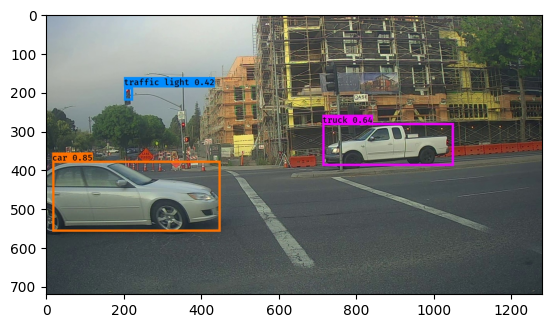

In [12]:
out_scores, out_boxes, out_classes = predict("0019.jpg")

## Using open cv to detect realtime

## Capturing screen

In [13]:
def capture_screen(region=None):
    with mss.mss() as sct:
        # Capture the screen
        screen = sct.grab(region if region else sct.monitors[1])
        # Convert to NumPy array
        img_np = np.array(screen)
        # Convert from BGRA to BGR
        img_np = cv2.cvtColor(img_np, cv2.COLOR_BGRA2BGR)
        return img_np

# Define the region (optional) - (left, top, width, height)
region = (0, 0, 960, 1080)  # Capture the left half of a 1920x1080 screen


In [ ]:
# Capture the screen
while True:
    # Capture the screen
    screen_img = capture_screen(region)
    out_scores, out_boxes, out_classes,output_image = predict_realtime(screen_img)
    
    # Display the captured image using OpenCV
    cv2.imshow('Screen Capture', screen_img)
    cv2.imshow('Box Capture', output_image)
    
    # Check for user input to exit the loop
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Clean up and close windows
cv2.destroyAllWindows()

# Display the captured image using OpenCV
cv2.imshow('Screen Capture', screen_img)
cv2.waitKey(0)
cv2.destroyAllWindows()


## Capturing webcam

In [14]:
def capture_webcam():
    # Initialize webcam
    cap = cv2.VideoCapture(0)
    
    if not cap.isOpened():
        print("Error: Could not open webcam.")
        return None

    return cap

def process_frame(frame):
    # You can apply any processing or prediction logic here
    out_scores, out_boxes, out_classes, output_image = predict_realtime(frame)
    return output_image

# Capture video from webcam
cap = capture_webcam()

if cap:
    while True:
        # Capture frame-by-frame
        ret, frame = cap.read()
        
        if not ret:
            print("Failed to grab frame")
            break

        # Process the frame (apply YOLO or any other detection logic)
        output_image = process_frame(frame)
        output_image = cv2.cvtColor(output_image, cv2.COLOR_RGB2BGR)
        

        # Display the resulting frame
        cv2.imshow('Webcam Capture', frame)
        cv2.imshow('Detection Capture', output_image)

        # Break the loop on 'q' key press
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # When everything is done, release the capture
    cap.release()
    cv2.destroyAllWindows()




Drawing box: person 0.85
Coordinates: top=207, left=53, bottom=480, right=482
Drawing box: person 0.88
Coordinates: top=211, left=52, bottom=480, right=480
Drawing box: toothbrush 0.35
Coordinates: top=589, left=331, bottom=480, right=404
Drawing box: person 0.90
Coordinates: top=202, left=44, bottom=480, right=486
Drawing box: kite 0.36
Coordinates: top=9, left=88, bottom=96, right=145
Drawing box: person 0.90
Coordinates: top=199, left=42, bottom=480, right=491
Drawing box: kite 0.62
Coordinates: top=6, left=87, bottom=97, right=145
Drawing box: person 0.89
Coordinates: top=201, left=50, bottom=480, right=483
Drawing box: kite 0.64
Coordinates: top=4, left=87, bottom=97, right=147
Drawing box: person 0.90
Coordinates: top=203, left=55, bottom=480, right=475
Drawing box: kite 0.59
Coordinates: top=2, left=86, bottom=97, right=147
Drawing box: person 0.91
Coordinates: top=203, left=53, bottom=480, right=476
Drawing box: kite 0.45
Coordinates: top=3, left=86, bottom=96, right=146
Drawin